In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library

In [ ]:
import os
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import torchvision

## Dataset Frog

In [ ]:
class CustomFrogDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = os.path.basename(file_path).split('_')[0]
        label_dict = {
            'Boana': 0,
            'Pool': 1,
            'PepperFrog': 2,
            'South': 3,
            'Dendropsophus': 4,
            'Leptodactylus': 5,
            'Rana': 6,
            'Rhinella': 7,
            'Scinax': 8
        }
        label = label_dict[label]

        # Load MFCC
        image = np.load(file_path)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        # Pastikan mengembalikan tensor gambar dan label
        return image, torch.tensor(label, dtype=torch.long)

# Transformations with Data Augmentation including Shear
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Konversi ke grayscale
    transforms.Resize((224, 224)),               # Resize gambar ke 224x224
    transforms.RandomAffine(degrees=10, shear=20),  # Affine transform
    transforms.ToTensor(),                      # Konversi ke tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load Data
train_files = glob('/content/drive/MyDrive/TUBES DL/Persiapan Data/Dataset/Test_Train_Val/train/*.npy')
val_files = glob('/content/drive/MyDrive/TUBES DL/Persiapan Data/Dataset/Test_Train_Val/val/*.npy')
test_files = glob('/content/drive/MyDrive/TUBES DL/Persiapan Data/Dataset/Test_Train_Val/test/*.npy')

train_dataset = CustomFrogDataset(train_files, transform=transform)
val_dataset = CustomFrogDataset(val_files, transform=transform)
test_dataset = CustomFrogDataset(test_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

class ModifiedDenseNet169(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(ModifiedDenseNet169, self).__init__()
        self.densenet169 = torchvision.models.densenet169(pretrained=True)  # Mengganti DenseNet-121 dengan DenseNet-169
        self.features = self.densenet169.features
        self.batch_norm1 = nn.BatchNorm2d(1664)  # Batch normalization setelah feature extraction (output dari DenseNet-169 adalah 1664)
        self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout tambahan setelah batch normalization
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Dropout tambahan sebelum classifier
        self.classifier = nn.Linear(self.densenet169.classifier.in_features, num_classes)

    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        # Batch normalization setelah feature extraction
        x = self.batch_norm1(x)
        # Aktivasikan ReLU
        x = F.relu(x, inplace=True)
        # Menambahkan adaptive pooling dan flatten
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)  # Flatten features
        # Dropout tambahan
        x = self.dropout1(x)  # Apply first Dropout
        # Classifier layer
        x = self.classifier(x)
        # Dropout sebelum klasifikasi akhir
        x = self.dropout2(x)  # Apply second Dropout

        return x

# Initialize model, criterion, optimizer, scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModifiedDenseNet169(num_classes=9).to(device)  # Menggunakan DenseNet-169
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Training loop
epochs = 30
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Training loop
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_accuracy = 100 * correct_preds / total_preds
    train_acc_history.append(train_accuracy)  # Store training accuracy
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%')

    # Validation loop
    model.eval()
    correct_preds = 0
    total_preds = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    val_accuracy = 100 * correct_preds / total_preds
    val_acc_history.append(val_accuracy)  # Store validation accuracy
    print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.2f}%')

    # Update scheduler
    scheduler.step(val_loss / len(val_loader))

# Test phase
model.eval()
correct_preds = 0
total_preds = 0
test_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_accuracy = 100 * correct_preds / total_preds
print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_accuracy:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 180MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  wa

Epoch [1/30], Train Loss: 2.1569, Train Acc: 18.32%
Val Loss: 2.1024, Val Acc: 22.22%
Epoch [2/30], Train Loss: 2.0343, Train Acc: 23.87%
Val Loss: 1.9950, Val Acc: 35.80%
Epoch [3/30], Train Loss: 1.9081, Train Acc: 28.08%
Val Loss: 1.8373, Val Acc: 45.68%
Epoch [4/30], Train Loss: 1.7868, Train Acc: 33.48%
Val Loss: 1.6572, Val Acc: 53.09%
Epoch [5/30], Train Loss: 1.7243, Train Acc: 36.04%
Val Loss: 1.5820, Val Acc: 50.62%
Epoch [6/30], Train Loss: 1.6002, Train Acc: 41.29%
Val Loss: 1.3856, Val Acc: 62.96%
Epoch [7/30], Train Loss: 1.5369, Train Acc: 39.64%
Val Loss: 1.4228, Val Acc: 61.73%
Epoch [8/30], Train Loss: 1.4647, Train Acc: 44.14%
Val Loss: 1.3083, Val Acc: 66.67%
Epoch [9/30], Train Loss: 1.4132, Train Acc: 45.50%
Val Loss: 1.1762, Val Acc: 62.96%
Epoch [10/30], Train Loss: 1.3920, Train Acc: 45.80%
Val Loss: 1.1868, Val Acc: 64.20%
Epoch [11/30], Train Loss: 1.2913, Train Acc: 48.05%
Val Loss: 1.0444, Val Acc: 70.37%
Epoch [12/30], Train Loss: 1.2371, Train Acc: 50.45%

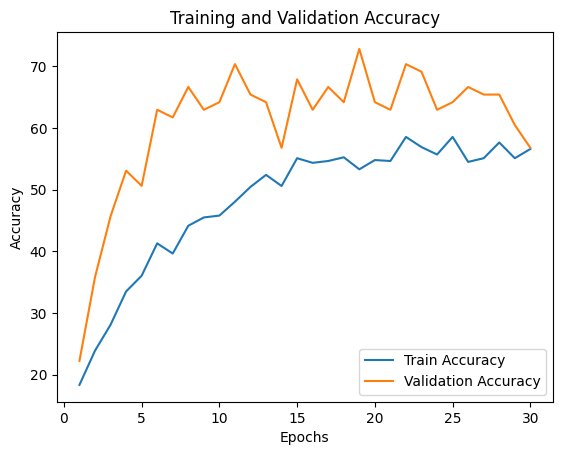

In [ ]:
plt.plot(range(1, epochs + 1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

In [ ]:
# Test Evaluation
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Akurasi: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Akurasi: 0.61
Precision: 0.68
Recall: 0.61
F1 Score: 0.62


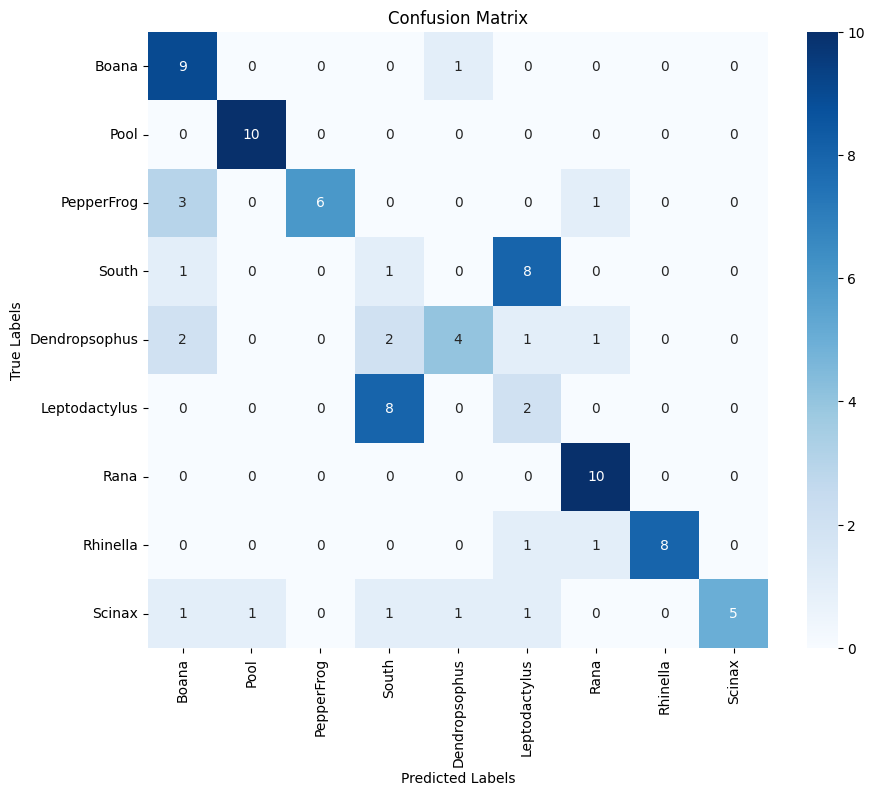

In [ ]:
class_labels = [
    'Boana',
    'Pool',
    'PepperFrog',
    'South',
    'Dendropsophus',
    'Leptodactylus',
    'Rana',
    'Rhinella',
    'Scinax'
]

# Hitung confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Simpan Model

In [6]:
# Inisialisasi model dengan num_classes=5
model = ModifiedDenseNet169(num_classes=9)
model_save_path = '/content/drive/MyDrive/TUBES DL/Model Transfer Learning/model_densenet169_frog_classifier_9_classes.pth'
torch.save(model.state_dict(), model_save_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 96.2MB/s]
<ipython-input-6-58a37cf6d2eb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly